# Feature Selection

In [1]:
%matplotlib notebook

In [2]:
import os
import json
import pingouin
import numpy as np
import pandas as pd
import datetime as dt
import multiprocessing

In [3]:
### Realizamos el cambio de directoroi de trabajo al "Directorio Base" que se
current_dir = os.getcwd()
base_path = os.path.dirname(current_dir)

os.chdir(base_path)

C:\Users\pasal\Anaconda3\envs\PI2\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
import scripts.auxiliares.GA as GA
import scripts.funciones as funciones

C:\Users\pasal\Anaconda3\envs\PI2\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Carga y Preparación de Datos

In [6]:
d_ini = dt.datetime(2017,6,1)
d_fin = dt.datetime(2019,8,1) 

In [7]:
%%time

version = 'verFinal'

### params
freq1 = '1D'
freq2 = '3D'
freq3 = '7D'
freq4 = '14D'
freq5 = '30D'
freq6 = '60D'
n_proc = multiprocessing.cpu_count() -1

### Realizamos la lectura de la informacion climatica en el rango de fechas
### especificado, incluye la etiqueta de si ocurre o no un accidente. 
### Posteriormente, en la organizacion de la informacion climatica, lo
### que se hace es agregar las variables con la informacion distribucional
### de las ultimas 5 horas de la info climatica
data = funciones.read_clima_accidentes(d_ini, d_fin, poblado = True)
data_org = funciones.organizar_data_infoClima(data)


### agregamos la informacion relacionada a la cantidad de accidentes ocurridas
### en las ultimas X horas
### Agregar senales
senales = [freq1, freq2, freq3, freq4, freq5, freq6]
d_ini_acc = d_ini - dt.timedelta(days = int(freq6.replace('D', '')))  ### freq mayor
raw_accidentes = funciones.read_accidentes(d_ini_acc, d_fin)
for fresen in senales:
    data_org = funciones.obtener_accidentes_acumulados(data_org, 
                                                        raw_accidentes, 
                                                        freq = fresen)


### Convertimos la bariable de Barrios en variable dummy para ser incluida
### en el modelo
data_org['poblado'] = data_org['BARRIO']
data_org= pd.get_dummies(data_org, columns=['poblado'])

### Relizamos la particion del conjunto de datos en las variables
### explicativas (X) y la variable respuesta (Y)
X = data_org.drop(columns = ['TW','BARRIO','Accidente','summary'])
Y = data_org['Accidente']       

Wall time: 36.3 s


In [8]:
### Dividimos el conjunto de datos en entrenamiento y validacion
X_train, X_val, Y_train, Y_val = train_test_split(X, 
                                                  Y,
                                                  stratify = Y,
                                                  test_size = 0.2,
                                                  random_state = 42)

train_indices = X_train.index.values
val_indices = X_val.index.values

In [9]:
%%time
### Realizamos resampling combinando Tomek Links y Random Undersampling

### Tomek Link
tomeklinks = TomekLinks()
X_tom, y_tom = tomeklinks.fit_sample(X_train, Y_train)

### Random Undersampling
rus = RandomUnderSampler(sampling_strategy = 30/70,random_state = 42)
X_train_under, Y_train_under = rus.fit_sample(X_train, Y_train)

Wall time: 6min 14s


In [10]:
train_indices = X_train.index.values[rus.sample_indices_]
test_indices = X_val.index.values

In [11]:
### Estandarizacion del conjunto de datos
scaler = StandardScaler()
scaler.fit(X_train_under)

X_train_under_z = pd.DataFrame(scaler.transform(X_train_under), columns = X_train_under.columns)
X_val_z = pd.DataFrame(scaler.transform(X_val), columns = X_val.columns)

X_z = pd.DataFrame(scaler.transform(X), columns = X.columns)

In [12]:
print(f'Se cuentan con {len(X_train.columns)} variables para la seleccion')

Se cuentan con 108 variables para la seleccion


# Análisis de Correlación

In [13]:
X_rus = X_train_under.copy()
y_rus = Y_train_under.copy()

Obtención de correlaciones y correlaciones parciales

In [14]:
X_rus['Accidente'] = y_rus.copy()
corr_y = X_rus.corr()['Accidente']
pcorr_y = X_rus.pcorr()['Accidente']

In [15]:
#### Con valores absolutos
abs_corr = []
abs_pcorr = []
for i in range(len(corr_y)):
    abs_corr.append(abs(corr_y[i]))
    abs_pcorr.append(abs(pcorr_y[i]))
corr_full = pd.DataFrame(corr_y)
pcorr_full = pd.DataFrame(pcorr_y)
corr_full['abs'] = abs_corr.copy()
pcorr_full['abs'] = abs_pcorr.copy()

### Ordenrarlas
corr_full = corr_full.sort_values(by='abs', ascending=False)
pcorr_full = pcorr_full.sort_values(by='abs', ascending=False)

In [16]:
### Ordeno la matriz X segun las correlaciones parciales de forma ascendente (para que funcione
### bien el siguiente paso)
vars_ord = list(pcorr_full.index)
X_rus_ord = X_rus[vars_ord[1:][::-1]]

In [17]:
#### Calcula matriz de correlacion de las variables explicativas
corr_x = X_rus_ord.corr()
corr_x

,icon_partly-cloudy-night,icon_clear-night,dewPoint,dewPoint_mean,Mes_Junio,icon_fog,Mes_Diciembre,humidity,hora_20,cumAcc_3D,...,poblado_laaguacatala,hora_4,hora_0,festivo,hora_1,hora_3,hora_2,hora_17,hora_16,dia_sem_6
icon_partly-cloudy-night,1.000000,-0.039976,-0.377489,-0.362706,-0.019152,-0.039621,0.097201,0.150067,0.154380,-0.024259,...,-0.002792,0.104936,0.123480,0.023979,0.148090,0.125354,0.136594,-0.122253,-0.118443,0.030712
icon_clear-night,-0.039976,1.000000,-0.103755,-0.116892,-0.016333,-0.006145,0.040463,-0.009530,0.032973,0.000921,...,0.017114,0.005507,0.004445,0.018443,0.005857,0.005565,0.002028,-0.018962,-0.018371,0.004387
dewPoint,-0.377489,-0.103755,1.000000,0.959595,0.012817,-0.142975,-0.101061,0.329523,-0.003116,0.033519,...,-0.008155,-0.117600,-0.091059,-0.047291,-0.089372,-0.103032,-0.081014,0.023762,0.023529,-0.028102
dewPoint_mean,-0.362706,-0.116892,0.959595,1.000000,0.012402,-0.141513,-0.102351,0.282642,0.017492,0.034779,...,-0.008848,-0.092560,-0.078249,-0.045602,-0.085578,-0.098219,-0.080507,0.025925,0.046436,-0.026705
Mes_Junio,-0.019152,-0.016333,0.012817,0.012402,1.000000,-0.003480,-0.092088,-0.021656,-0.003555,-0.000824,...,0.007554,-0.013394,-0.007784,0.019878,0.012378,-0.008762,0.011879,-0.013677,0.007042,0.014142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hora_3,0.125354,0.005565,-0.103032,-0.098219,-0.008762,0.065695,0.008353,0.138429,-0.037002,-0.024088,...,-0.008985,-0.032597,-0.033674,0.003782,-0.032250,1.000000,-0.032075,-0.043439,-0.042085,0.010217
hora_2,0.136594,0.002028,-0.081014,-0.080507,0.011879,0.022507,-0.003509,0.136640,-0.036475,-0.009342,...,-0.014335,-0.032132,-0.033194,0.016650,-0.031790,-0.032075,1.000000,-0.042819,-0.041485,0.012226
hora_17,-0.122253,-0.018962,0.023762,0.025925,-0.013677,-0.018794,0.003364,-0.135726,-0.049397,0.015287,...,0.003361,-0.043515,-0.044954,-0.009060,-0.043052,-0.043439,-0.042819,1.000000,-0.056182,-0.028881
hora_16,-0.118443,-0.018371,0.023529,0.046436,0.007042,-0.015059,0.001713,-0.196215,-0.047857,0.010944,...,-0.001981,-0.042159,-0.043553,-0.013147,-0.041711,-0.042085,-0.041485,-0.056182,1.000000,-0.000458


In [18]:
### Valor de correlacion umbral (si algun par de variables explicativas tiene
### una correlacion mayor a esta, se elimina la variable de este par que 
### tenga una menor correlacion parcial con la variable de salida)
cor_umb = 0.95

variabs = list(X_rus_ord.columns)
X_rus_aux = X_rus_ord.copy()

for va in variabs:
    esta_col = corr_x[va]
    if np.sort(esta_col)[-2]>cor_umb:
        X_rus_aux = X_rus_aux.drop(columns=va)
        corr_x = X_rus_aux.corr()
        print(f'Elimina variable {va}')

Elimina variable dewPoint
Elimina variable humidity
Elimina variable apparentTemperature_mean_forward
Elimina variable cumAcc_60D
Elimina variable temperature
Elimina variable apparentTemperature
Elimina variable apparentTemperature_mean


In [19]:
### mantengo solo las variables que no se eliminaron
X_train_under = X_train_under[X_rus_aux.columns]
X_train = X_train[X_rus_aux.columns]
X_val = X_val[X_rus_aux.columns]

X_train_under_z = X_train_under_z[X_rus_aux.columns]
X_val_z = X_val_z[X_rus_aux.columns]

print(f'Se cuentan con {len(X_train_under.columns)} variables para la seleccion')

Se cuentan con 101 variables para la seleccion


# Lasso Variable Selection

In [ ]:
%%time

C = np.logspace(-2.0,2.0,num = 1000)#np.arange(1, 10**2, 1)
par = {'C': C}

lasso_mod = GridSearchCV(LogisticRegression(penalty = 'l1', solver = 'liblinear'), 
                         par,
                         scoring = 'roc_auc',
                         cv = 2,
                         verbose = 2,
                         n_jobs = n_proc)

lasso_mod.fit(X_train_under_z, Y_train_under)
coeficientes = lasso_mod.best_estimator_.coef_[0]

res = pd.DataFrame()
res['Var'] = X_train.columns
res['coef'] = coeficientes
res['coef_abs'] = res['coef'].abs()

vars_lasso = res[res['coef_abs']>0].Var.values

### Evaluacion del modelo con las variables obtenidas
clf_lasso = XGBClassifier(n_estimators = 300, 
                          max_depth = 2,
                          random_state = 42)

clf_lasso.fit(X_train_under_z[vars_lasso], Y_train_under)

### Metricas en validation

preds_val = clf_lasso.predict_proba(X_val_z[vars_lasso])
ROC_val_lasso = roc_auc_score(Y_val,preds_val[:,1])
PR_val_lasso = funciones.precision_recall_auc_score(Y_val,preds_val[:,1])

print(f'Se seleccionaron {len(vars_lasso)} variables, se obtuvo un ROC-AUC de {ROC_val_lasso} en Validacion\n')
print(f'Se seleccionaron {len(vars_lasso)} variables, se obtuvo un PR-AUC de {PR_val_lasso} en Validacion\n')
print(vars_lasso)

In [ ]:
### Evaluacion del modelo con las variables obtenidas
clf_lasso = XGBClassifier(n_estimators = 300, 
                          max_depth = 2,
                          random_state = 42)

clf_lasso.fit(X_train_under_z[vars_lasso], Y_train_under)

### Metricas en validation

preds_val = clf_lasso.predict_proba(X_val_z[vars_lasso])
ROC_val_lasso = roc_auc_score(Y_val,preds_val[:,1])
PR_val_lasso = funciones.precision_recall_auc_score(Y_val,preds_val[:,1])

print(f'Se seleccionaron {len(vars_lasso)} variables, se obtuvo un ROC-AUC de {ROC_val_lasso} en Validacion\n')
print(f'Se seleccionaron {len(vars_lasso)} variables, se obtuvo un PR-AUC de {PR_val_lasso} en Validacion\n')
print(vars_lasso)

# Backward Variable Selection

In [ ]:
%%time

### Seleccion de variables con un Forward Selection
clf = MLPClassifier(hidden_layer_sizes = (30,57),
                    learning_rate_init = 0.001 ,
                    alpha = 3 ,
                    solver = 'adam',
                    shuffle = True, 
                    activation = 'relu',
                    random_state= 42)

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features='best',
           forward=False,
           floating=False,
           verbose=2,
           scoring='roc_auc',
           cv=2,
           n_jobs = n_proc)

# Perform SFFS
sfs1 = sfs1.fit(X_train_under_z, Y_train_under)

# Which features?
feat_cols = list(sfs1.k_feature_idx_)
var_relevant = list(X_train_under_z.columns[feat_cols])

### Evaluacion del modelo con las variables obtenidas
clf_forward = XGBClassifier(n_estimators = 300, 
                          max_depth = 2,
                          random_state = 42)

clf_forward.fit(X_train_under_z[var_relevant], Y_train_under)

### Metricas en validation

preds_val = clf_forward.predict_proba(X_val_z[var_relevant])
ROC_val_forward = roc_auc_score(Y_val,preds_val[:,1])
PR_val_forward = funciones.precision_recall_auc_score(Y_val,preds_val[:,1])

print(f'Se seleccionaron {len(var_relevant)} variables, se obtuvo un ROC-AUC de {ROC_val_forward} en Validacion\n')
print(f'Se seleccionaron {len(var_relevant)} variables, se obtuvo un PR-AUC de {PR_val_forward} en Validacion\n')
print(var_relevant)

In [ ]:
### Evaluacion del modelo con las variables obtenidas
clf_forward = XGBClassifier(n_estimators = 300, 
                          max_depth = 2,
                          random_state = 42)

clf_forward.fit(X_train_under_z[var_relevant], Y_train_under)

### Metricas en validation

preds_val = clf_forward.predict_proba(X_val_z[var_relevant])
ROC_val_forward = roc_auc_score(Y_val,preds_val[:,1])
PR_val_forward = funciones.precision_recall_auc_score(Y_val,preds_val[:,1])

print(f'Se seleccionaron {len(var_relevant)} variables, se obtuvo un ROC-AUC de {ROC_val_forward} en Validacion\n')
print(f'Se seleccionaron {len(var_relevant)} variables, se obtuvo un PR-AUC de {PR_val_forward} en Validacion\n')
print(var_relevant)

# Algoritmo Genético para Selección de Características

In [20]:
### Modelo base de la envoltura
classifier = RandomForestClassifier(bootstrap=False,  
                             criterion='entropy',
                             max_features='auto',
                             n_estimators=500, 
                             max_depth=10,
                             random_state=42,
                             warm_start=False)

Mejor solucion :  [0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 1
 1 0 1 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0
 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1]
Indices seleccionados :  [  4   6   8   9  10  11  12  14  19  25  26  31  32  34  35  36  37  39
  41  42  43  44  45  47  50  52  54  55  57  60  63  66  67  68  75  77
  79  80  82  83  85  86  87  88  90  92  94  95  97  98  99 100]
Numero de variables seleccionadas :  52
PR-AUC de la mejor solucion de todo el algoritmo :  0.0606487841477701


<IPython.core.display.Javascript object>


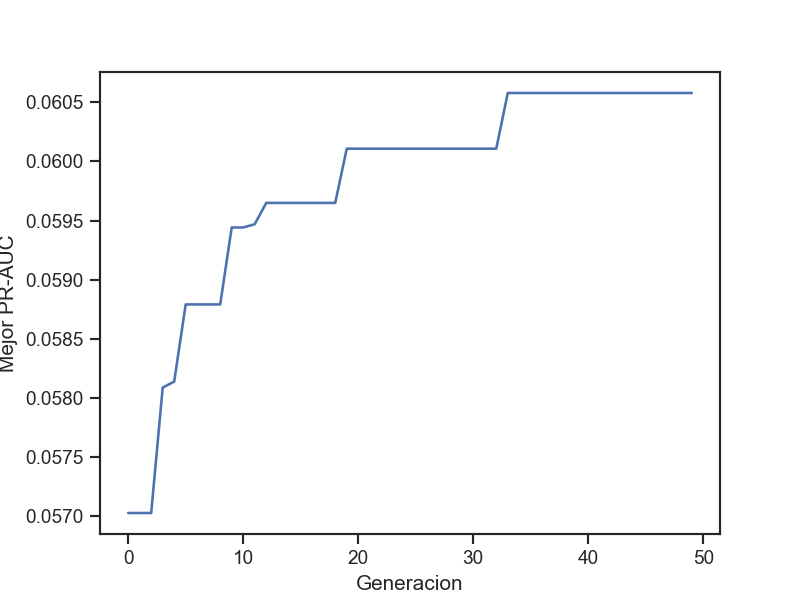

Wall time: 2h 43min 39s


In [24]:
%%time
### Ejecucion del Algoritmo Genetico

### Hiperparametros
num_samples = X_train_under_z.shape[0]
num_feature_elements = X_train_under_z.shape[1]

num_generations = 50   ### Numero de generaciones
sol_per_pop = 20 # Tamano de poblacion de cada generacion
num_parents_mating = int(sol_per_pop/2) # Cuantos padres se cruzaran 

porc_mutation = 0.2 # Proporcion de hijos a los que se le aplica el operador de mutacion.
num_mutations = int((sol_per_pop-num_parents_mating)*porc_mutation)

porc_genes = 0.05   ### Porcentaje de los genes que se varian al mutar
num_genes = int(num_feature_elements*porc_genes)

X_z = X_z[X_train.columns]

data_inputs, data_outputs = X_z.values, Y.values

### Correr el algoritmo genético
best_solution, best_solution_indices, best_solution_num_elements, best_solution_fitness = GA.genetic_algorithm(X_train,num_generations, sol_per_pop, porc_mutation, porc_genes,
                                                                                                              num_feature_elements,data_inputs, data_outputs, 
                                                                                                              train_indices, test_indices, classifier, num_mutations,num_genes)


In [25]:
### Las variables obtenidas son
vars_obt = []
for i in range(len(best_solution)):
    if best_solution[i]==1:
        vars_obt.append(X_train.columns[i])

### Evaluacion del modelo con las variables obtenidas
clf_AG = XGBClassifier(n_estimators = 300, 
                          max_depth = 2,
                          random_state = 42)

clf_AG.fit(X_train_under_z[vars_obt], Y_train_under)

### Metricas en validation

preds_val = clf_AG.predict_proba(X_val_z[vars_obt])
ROC_val_AG = roc_auc_score(Y_val,preds_val[:,1])
PR_val_AG = funciones.precision_recall_auc_score(Y_val,preds_val[:,1])
        
print(f'Se seleccionaron {len(vars_obt)} variables, se obtuvo un ROC-AUC de {ROC_val_AG} en Validacion\n')
print(f'Se seleccionaron {len(vars_obt)} variables, se obtuvo un PR-AUC de {PR_val_AG} en Validacion\n')
print(vars_obt)

Se seleccionaron 52 variables, se obtuvo un ROC-AUC de 0.770396644702265 en Validacion

Se seleccionaron 52 variables, se obtuvo un PR-AUC de 0.05795308577748147 en Validacion

['icon_fog', 'hora_20', 'precipIntensity_mean', 'icon_cloudy', 'icon_clear-day', 'precipIntensity_mean_forward', 'uvIndex', 'Year_2019', 'precipIntensity', 'Mes_Julio', 'icon_rain', 'Mes_Agosto', 'Year_2017', 'poblado_losbalsosno2', 'temperature_mean_forward', 'cloudCover_mean', 'Mes_Abril', 'cumAcc_30D', 'dewPoint_mean_forward', 'poblado_laslomasno1', 'Year_2018', 'precipProbability', 'Mes_Mayo', 'Mes_Septiembre', 'hora_8', 'windSpeed_mean', 'visibility_mean', 'visibility', 'Mes_Enero', 'hora_13', 'poblado_laflorida', 'hora_11', 'dia_sem_5', 'hora_22', 'poblado_castropol', 'dia_sem_4', 'hora_15', 'poblado_barriocolombia', 'poblado_astorga', 'hora_23', 'poblado_lalinde', 'poblado_altosdelpoblado', 'poblado_manila', 'poblado_eldiamanteno2', 'poblado_elpoblado', 'hora_4', 'festivo', 'hora_1', 'hora_2', 'hora_17', 

In [26]:
### Las variables obtenidas son
vars_obt = []
for i in range(len(best_solution)):
    if best_solution[i]==1:
        vars_obt.append(X_train.columns[i])

### Evaluacion del modelo con las variables obtenidas
clf_AG = classifier

clf_AG.fit(X_train_under_z[vars_obt], Y_train_under)

### Metricas en validation

preds_val = clf_AG.predict_proba(X_val_z[vars_obt])
ROC_val_AG = roc_auc_score(Y_val,preds_val[:,1])
PR_val_AG = funciones.precision_recall_auc_score(Y_val,preds_val[:,1])
        
print(f'Se seleccionaron {len(vars_obt)} variables, se obtuvo un ROC-AUC de {ROC_val_AG} en Validacion\n')
print(f'Se seleccionaron {len(vars_obt)} variables, se obtuvo un PR-AUC de {PR_val_AG} en Validacion\n')
print(vars_obt)

Se seleccionaron 52 variables, se obtuvo un ROC-AUC de 0.7714862761887894 en Validacion

Se seleccionaron 52 variables, se obtuvo un PR-AUC de 0.0606487841477701 en Validacion

['icon_fog', 'hora_20', 'precipIntensity_mean', 'icon_cloudy', 'icon_clear-day', 'precipIntensity_mean_forward', 'uvIndex', 'Year_2019', 'precipIntensity', 'Mes_Julio', 'icon_rain', 'Mes_Agosto', 'Year_2017', 'poblado_losbalsosno2', 'temperature_mean_forward', 'cloudCover_mean', 'Mes_Abril', 'cumAcc_30D', 'dewPoint_mean_forward', 'poblado_laslomasno1', 'Year_2018', 'precipProbability', 'Mes_Mayo', 'Mes_Septiembre', 'hora_8', 'windSpeed_mean', 'visibility_mean', 'visibility', 'Mes_Enero', 'hora_13', 'poblado_laflorida', 'hora_11', 'dia_sem_5', 'hora_22', 'poblado_castropol', 'dia_sem_4', 'hora_15', 'poblado_barriocolombia', 'poblado_astorga', 'hora_23', 'poblado_lalinde', 'poblado_altosdelpoblado', 'poblado_manila', 'poblado_eldiamanteno2', 'poblado_elpoblado', 'hora_4', 'festivo', 'hora_1', 'hora_2', 'hora_17', 

# Guardamos los resultados obtenidos

En un archivo JSON guardamos los resultados de los 3 metodos

In [ ]:
Resultados = {'lasso':{'num_features':len(vars_lasso),
                       'roc_val': ROC_val_lasso,
                       'pr_val': PR_val_lasso,
                       'features':list(vars_lasso)},
              'forward':{'num_features':len(var_relevant),
                       'roc_val': ROC_val_forward,
                         'pr_val': PR_val_forward,
                       'features':var_relevant},
              'AG':{'num_features':len(vars_obt),
                    'roc_val': ROC_val_AG,
                    'pr_val': PR_val_AG,
                    'features':vars_obt}
              }


with open(f'{base_path}/models/{version}/analisis_var_relevantes.json','w') as json_file:
    json.dump(Resultados, json_file)